<h1> Classification d'abeilles </h1>



## Chargement des données

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2024-03-26 13:06:30.077974: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 13:06:31.516986: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### test

In [2]:
# Paramètres
IMG_SIZE = 320 # pour utiliser ResNet

In [3]:
train_dir = "/mnt/disk1/datasets/Projet_Bees_Detection_Basile/data_bees_detection/BD307/BD_307_cropped/dataset/train/"
val_dir = "/mnt/disk1/datasets/Projet_Bees_Detection_Basile/data_bees_detection/BD307/BD_307_cropped/dataset/val/"

In [4]:
import os
import glob
import cv2

from albumentations import (Compose, Rotate, HorizontalFlip, VerticalFlip, Affine, RandomBrightnessContrast, ChannelShuffle)
import albumentations as A
from functools import partial
# from tensor

AUGMENTATIONS_TRAIN = Compose([
    Rotate(limit=[0,100], p=0.5),
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    Affine(shear=[-45, 45], p=0.5),
    RandomBrightnessContrast(p=0.5)
])   

def get_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img / 255.0, tf.float32) # normalize image
    return img

def process_path(file_path, label):
    img = get_image(file_path)
    # label = tf.one_hot(label, nb_classes)
    return img, label

def augment_image(image, img_size):
    img = cv2.imread(image.decode('utf-8'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    aug_data = AUGMENTATIONS_TRAIN(image=img)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32) # normalize image
    return tf.image.resize(aug_img, size=[img_size, img_size])

def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=augment_image, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label

def set_shapes(img, label, img_shape=(IMG_SIZE,IMG_SIZE,3)):
    img.set_shape(img_shape)
    label = tf.one_hot(label, nb_classes)
    return img, label

train_images = glob.glob(os.path.join(train_dir, "*/*"))
train_labels = [img.split("/")[-2] for img in train_images]
class_names = sorted(set(train_labels))
nb_classes = len(class_names)
train_labels = [class_names.index(l) for l in train_labels]
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_image_count = len(train_ds)
train_ds = train_ds.shuffle(train_image_count, reshuffle_each_iteration=False)
# train_ds = train_ds.map(aug_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# create dataset
train_ds = train_ds.map(partial(process_data, img_size=IMG_SIZE),
                  num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
train_ds = train_ds.map(set_shapes, num_parallel_calls=tf.data.AUTOTUNE)

print("Class Names: ", class_names)
print("Number of classes: ", nb_classes)
print("Number of train images: ", train_image_count)


val_images = glob.glob(os.path.join(val_dir, "*/*"))
val_labels = [img.split("/")[-2] for img in val_images]
val_labels = [class_names.index(l) for l in val_labels]
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_image_count = len(val_ds)
val_ds = val_ds.shuffle(val_image_count, reshuffle_each_iteration=False)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

print("Number of val images: ", val_image_count)


def configure_for_performance(ds):
  ds = ds.cache()
#   ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size=16)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
print("\nData loaded & Optimized for performance.")



2024-03-26 13:06:39.254904: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9840 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1
2024-03-26 13:06:39.255682: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10527 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:a1:00.0, compute capability: 6.1


Class Names:  ['Aglaoapis tridentata', 'Amegilla albigena', 'Amegilla garrula', 'Amegilla quadrifasciata', 'Andrena agilissima', 'Andrena albopunctata', 'Andrena apicata', 'Andrena barbilabris', 'Andrena bicolor', 'Andrena bicolorata', 'Andrena bimaculata', 'Andrena carantonica', 'Andrena chrysosceles', 'Andrena cineraria', 'Andrena clarkella', 'Andrena colletiformis', 'Andrena denticulata', 'Andrena dorsata', 'Andrena flavipes', 'Andrena florea', 'Andrena fulva', 'Andrena fuscipes', 'Andrena fuscosa', 'Andrena gravida', 'Andrena haemorrhoa', 'Andrena hattorfiana', 'Andrena helvola', 'Andrena humilis', 'Andrena labialis', 'Andrena labiata', 'Andrena lagopus', 'Andrena leucolippa', 'Andrena limbata', 'Andrena marginata', 'Andrena minutula', 'Andrena morio', 'Andrena nigriceps', 'Andrena nigroaenea', 'Andrena nitida', 'Andrena nycthemera', 'Andrena ovatula', 'Andrena pandellei', 'Andrena pilipes', 'Andrena praecox', 'Andrena propinqua', 'Andrena proxima', 'Andrena ranunculi', 'Andrena ro

2024-03-26 13:06:43.180236: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


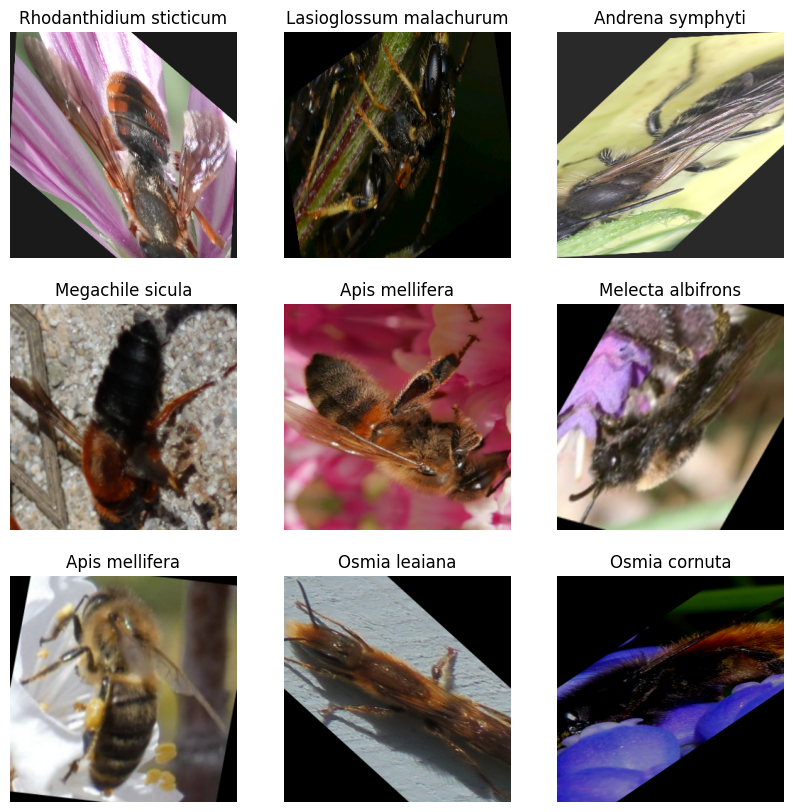

In [5]:
import matplotlib.pyplot as plt

image_batch, label_batch = next(iter(train_ds))
label_batch = tf.argmax(label_batch, axis=1)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("float32"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")


In [6]:
import numpy as np

for image, label in train_ds.take(2):
    image = np.array(image)
    print("Image shape: ", image.shape)
    print("Label: ", label.numpy().argmax())

Image shape:  (16, 320, 320, 3)
Label:  280
Image shape:  (16, 320, 320, 3)
Label:  59


2024-03-26 13:06:47.531772: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-03-26 13:06:48.433301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
import tensorflow as tf

conv_base = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling=None,
    classes=nb_classes
)


# conv_base = tf.keras.applications.resnet.ResNet101(
#     include_top=False,
#     weights='imagenet',
#     input_tensor=None,
#     input_shape=(IMG_SIZE, IMG_SIZE, 3),
#     pooling=None,
#     classes=nb_classes,
# )

# conv_base = tf.keras.applications.EfficientNetB0(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(IMG_SIZE, IMG_SIZE, 3),
#     pooling=None,
#     classes=nb_classes
# )

# conv_base = tf.keras.applications.mobilenet.MobileNet(
#     input_shape=(IMG_SIZE, IMG_SIZE, 3),
#     include_top=False,
#     weights='imagenet',
#     input_tensor=None,
#     pooling=None,
#     classes=nb_classes
# )


inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(nb_classes, kernel_regularizer=regularizers.L2(1e-4), activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="bee_classifier")

model.summary()

Model: "bee_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 10, 10, 2048)   │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 306)            │       626,994 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,214,706 (92.37 MB)

 Trainable params: 24,161,586 (92.17 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [8]:
for image, label in train_ds.take(2):
    output = model(image)
    print(output.shape, output.numpy().argmax(axis=1))

2024-03-26 13:06:52.240337: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


(16, 306) [46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46]


2024-03-26 13:06:55.138625: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(16, 306) [46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46]


2024-03-26 13:06:55.393926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### end of test

### Poids INat2021

In [9]:
# from tensorflow import keras
# conv_base = keras.models.load_model('drive/MyDrive/Stage2A/INat2021/2623871_resnet50_simclr_v1_inat20_no_top.h5')

# model = keras.Sequential(
#     [
#         conv_base,
#         layers.Dense(nb_classes, kernel_regularizer=regularizers.L2(1e-4), activation='softmax')
#     ]
# )

In [10]:
# model.summary()

## Hierarchical loss

In [11]:
import pandas as pd
import numpy as np

hierarchy_csv = "/home/eremy/Documents/CODE/bound_v1/dataset_analysis/306_hierarchy.csv"
hierarchy = pd.read_csv(hierarchy_csv)

specie = list(hierarchy["specie"].unique())
nb_specie = len(specie)

genus = list(hierarchy["genus"].unique())
nb_genus = len(genus)

family = list(hierarchy["family"].unique())
nb_family = len(family)

order = list(hierarchy["order"].unique())
nb_order = len(order)

class_ = list(hierarchy["class"].unique())
nb_class = len(class_)

species_to_genus = np.zeros((nb_genus, nb_specie))
genus_to_family = np.zeros((nb_family, nb_genus))
family_to_order = np.zeros((nb_order, nb_family))
order_to_class = np.zeros((nb_class, nb_order))

for i in range(nb_specie):
  # specie -> genus
  genus_species = hierarchy.at[i, "genus"]
  ind_genus = genus.index(genus_species)
  species_to_genus[ind_genus, i] = 1

  # genus -> family
  family_species = hierarchy.at[i, "family"]
  ind_family = family.index(family_species)
  genus_to_family[ind_family, ind_genus] = 1

  # family -> order
  order_species = hierarchy.at[i, "order"]
  ind_order = order.index(order_species)
  family_to_order[ind_order, ind_family] = 1

  # order -> class
  class_species = hierarchy.at[i, "class"]
  ind_class = class_.index(class_species)
  order_to_class[ind_class, ind_order] = 1

In [12]:
from numpy.ma.core import transpose
# from keras import backend as K
import math
import tensorflow as tf

categorical_crossentropy = tf.keras.losses.CategoricalCrossentropy()
alpha = 0.5
weight0 = math.exp(-alpha * 0)
weight1 = math.exp(-alpha * 1)
weight2 = math.exp(-alpha * 2)
weight3 = math.exp(-alpha * 3)


# Définition de la fonction de perte
def Hierarchicaloss(specie_to_genus, genus_to_family, family_to_order, batch_size, alpha=0.1):

    # def weight(height=1):
    #   return math.exp(-alpha * height)
    
    def specie_loss(y_true, y_pred):
      # height = 0
      return weight0 * categorical_crossentropy(y_true, y_pred)
  
    def specie_to_genus_loss(y_true, y_pred):
      # height = 1
      y_true_genus = tf.transpose(tf.raw_ops.MatMul(a=specie_to_genus, b=tf.cast(y_true, tf.float64), transpose_b=True))
      y_pred_genus = tf.transpose(tf.raw_ops.MatMul(a=specie_to_genus, b=tf.cast(y_pred, tf.float64), transpose_b=True))
      return weight1 * categorical_crossentropy(y_true_genus, y_pred_genus), y_true_genus, y_pred_genus
    
    def genus_to_family_loss(y_true, y_pred):
      # height = 2
      y_true_family = tf.transpose(tf.raw_ops.MatMul(a=genus_to_family, b=y_true, transpose_b=True))
      y_pred_family = tf.transpose(tf.raw_ops.MatMul(a=genus_to_family, b=y_pred, transpose_b=True))
      return weight2 * categorical_crossentropy(y_true_family, y_pred_family), y_true_family, y_pred_family
    
    def family_to_order_loss(y_true, y_pred):
      # height = 3
      y_true_order = tf.transpose(tf.raw_ops.MatMul(a=family_to_order, b=y_true, transpose_b=True))
      y_pred_order = tf.transpose(tf.raw_ops.MatMul(a=family_to_order, b=y_pred, transpose_b=True))
      return weight3 * categorical_crossentropy(y_true_order, y_pred_order)#, y_true_order, y_pred_order

    def HIERARCHICAL_loss(y_true, y_pred):
      loss_specie = specie_loss(y_true, y_pred)
      loss_genus, y_true_genus, y_pred_genus = specie_to_genus_loss(y_true, y_pred)
      loss_family, y_true_family, y_pred_family = genus_to_family_loss(y_true_genus, y_pred_genus)
      # loss_order, y_true_order, y_pred_order = family_to_order_loss(y_true_family, y_pred_family)
      loss_order = family_to_order_loss(y_true_family, y_pred_family)

      return (loss_specie + loss_genus + loss_family + loss_order)/batch_size
   
    # Return a function
    return HIERARCHICAL_loss

In [13]:
hierarchy_loss=[Hierarchicaloss(species_to_genus, genus_to_family, family_to_order, batch_size=16, alpha=0.5)]

## Entraînement du modèle

In [14]:
# Ajout de l'optimiseur, de la fonction coût et des métriques
lr = 1e-3
model.compile(optimizers.SGD(learning_rate=lr, momentum=0.9), loss=hierarchy_loss, metrics=['categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [15]:
# Les callbacks
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='./ResNet.weights.h5',
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

#early_stopping_cb = tf.keras.callbacks.EarlyStopping(
#    monitor="val_categorical_accuracy",
#    min_delta=0.01,
#    patience=8,
#    verbose=1,
#    mode="auto")
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.1,
                              patience=5, min_lr=0.00001, verbose=1)

In [16]:
history = model.fit(train_ds, epochs=100, validation_data = val_ds, callbacks=[model_checkpoint_cb, reduce_lr_cb])

Epoch 1/100


/home/eremy/Documents/CODE/venv/env2_tf/lib/python3.11/site-packages/keras/src/losses/losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)
I0000 00:00:1711454836.259584   17233 service.cc:145] XLA service 0x784fb0002940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1711454836.259759   17233 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
I0000 00:00:1711454836.259793   17233 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-03-26 13:07:17.715501: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0

2847/5211 ━━━━━━━━━━━━━━━━━━━━ 27:47 706ms/step - categorical_accuracy: 0.2184 - loss: 0.4838 - precision: 0.7974 - recall: 0.1243